# **Project 2 of ECE 232E**
# **Social Network Mining**
# **3. Cora Dataset**

### QUESTION 23: Idea 1

In [2]:
!pip install spektral
!pip install Keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 6.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np

import tensorflow as tf

import keras
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dropout
from keras.regularizers import l2
from keras.metrics import CategoricalAccuracy

import spektral
from spektral.datasets.citation import Cora
from spektral.layers import GCNConv
from spektral.transforms import AdjToSpTensor, LayerPreprocess

import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)
print(spektral.__version__)


2.12.0
2.12.0
1.2.0


Pre-processing node features


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


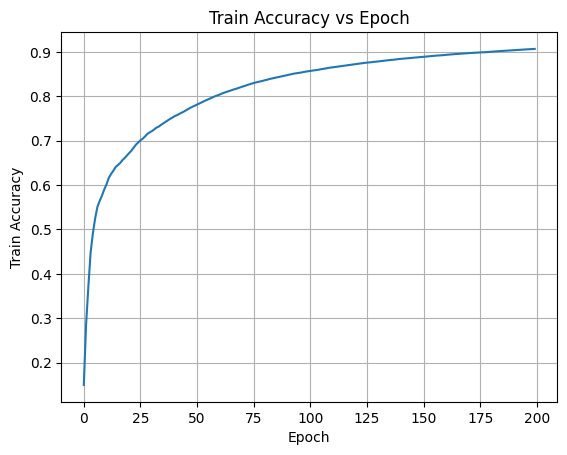

Number of train set:  140
Number of test set:  2568

n_channels:  16
dropout_rate:  0.5
l2_reg :  0.00025
learning_rate:  0.01
n_epochs:  200

Test Accuracy:  tf.Tensor(0.70911217, shape=(), dtype=float32)


In [7]:
# Define Model --------------------------------------------------------------------------------------
class Cora_GCN(Model):
    
    def __init__(self, n_labels, n_channels=16, activation="relu", output_activation="softmax",
                 dropout_rate=0.5, l2_reg=2.5e-4, use_bias=False):
        super().__init__()
        self.n_labels = n_labels
        self.channels = n_channels
        self.activation = activation
        self.output_activation = output_activation
        self.dropout_rate = dropout_rate
        self.l2_reg = l2(l2_reg)
        self.use_bias = use_bias
        
        self.drop_out1 = Dropout(dropout_rate)
        self.graph_conv1 = GCNConv(n_channels, activation=activation, kernel_regularizer=l2(l2_reg), use_bias=use_bias)
        self.drop_out2 = Dropout(dropout_rate)
        self.graph_conv2 = GCNConv(n_labels, activation=output_activation, use_bias=use_bias)

    def call(self, inputs):
        assert(len(inputs) == 2)
        X, A = inputs
        outputs = self.drop_out1(X)
        outputs = self.graph_conv1([outputs, A])
        outputs = self.drop_out2(outputs)
        outputs = self.graph_conv2([outputs, A])
        return outputs


# Define Hyperparameters ----------------------------------------------------------------------------
tf.random.set_seed(seed=0)
n_channels = 16
dropout_rate = 0.5
l2_reg = 2.5e-4
learning_rate = 1e-2
n_epochs = 200


# Get Data Set --------------------------------------------------------------------------------------
dataset = Cora(normalize_x=True, transforms=[LayerPreprocess(GCNConv), AdjToSpTensor()])    # cora dataset
X = dataset[0].x    # features data
A = dataset[0].a    # adjacent matrix
Y = dataset[0].y    # labels data
n_labels = dataset.n_labels   # numbers of label types
n_nodes = dataset.n_nodes   # numbers of nodes


# Split Data Set ------------------------------------------------------------------------------------
mask_train = dataset.mask_tr
mask_test = ~mask_train

# Define Model --------------------------------------------------------------------------------------
model = Cora_GCN(n_labels=n_labels, n_channels=n_channels, dropout_rate=dropout_rate, l2_reg=l2_reg)


# Training ------------------------------------------------------------------------------------------ 
optimizer = Adam(learning_rate=learning_rate)
loss_fn = CategoricalCrossentropy()
acc_train = CategoricalAccuracy(name='train_accuracy')
arr_acc_train = np.zeros(n_epochs)

for i in range(n_epochs):
    with tf.GradientTape() as tape:
        predicts = model([X, A], training=True)
        loss = loss_fn(Y[mask_train], predicts[mask_train])
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    arr_acc_train[i] = acc_train(Y[mask_train], predicts[mask_train])

plt.plot(range(n_epochs), arr_acc_train)
plt.title("Train Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.grid()
plt.show()
    
    
# Testing ------------------------------------------------------------------------------------------ 
acc_test = CategoricalAccuracy(name='test_accuracy')

predicts = model([X, A], training=True)
accuracy = acc_test(Y[mask_test], predicts[mask_test])

print("Number of train set: ", len(Y[mask_train]))
print("Number of test set: ", len(Y[mask_test]))

print("\nn_channels: ", n_channels)
print("dropout_rate: ", dropout_rate)
print("l2_reg : ", l2_reg )
print("learning_rate: ", learning_rate)
print("n_epochs: ", n_epochs)

print("\nTest Accuracy: ", accuracy)

* In this question, we used a GCN with two $GCNConv$ layers, each of them has $16$ $channels$ and a $dropout$ $rate$ of $0.5$, and the $l2$ $regularizer$ is set to be $2.5×10^{-4}$.
* For training, we set $learning$ $rate$ to be $0.01$, and we train the model with $200$ epochs. We have $140$ nodes for training, and $2568$ for testing.
* The final test accuracy is $0.72$.


### QUESTION 24: Idea 2

In [1]:
!pip install -q stellargraph[demos]==1.2.1 --ignore-requires-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 28.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.2 MB/s eta 0:00:00


In [39]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph 
from stellargraph import datasets
from IPython.display import display, HTML

from gensim.models import Word2Vec


# Get Dataset and Graph ---------------------------------------------------------------------------------
dataset = datasets.Cora()
G, node_subjects = dataset.load(largest_connected_component_only=True)
nodes = np.array(node_subjects.index)
labels = np.array(node_subjects.values)
df = pd.DataFrame(list(zip(nodes, labels)), columns=['node', 'label'])
seeds = df.groupby('label', group_keys=False).apply(lambda x: x.sample(20))
nodes_random_walk = list(seeds['node'])


# Perform Random Walk -----------------------------------------------------------------------------------
n_walks = 10
len_walk = 200
p = 0.5
q = 2.0
random_walker = BiasedRandomWalk(G)
walks = random_walker.run(nodes=nodes, n=n_walks, length=len_walk, p=p, q=q)
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(sentences=str_walks, vector_size=100, window=5, min_count=1, workers=4)


In [40]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs 
node_embeddings = (model.wv.vectors)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]] # pd.Series

# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

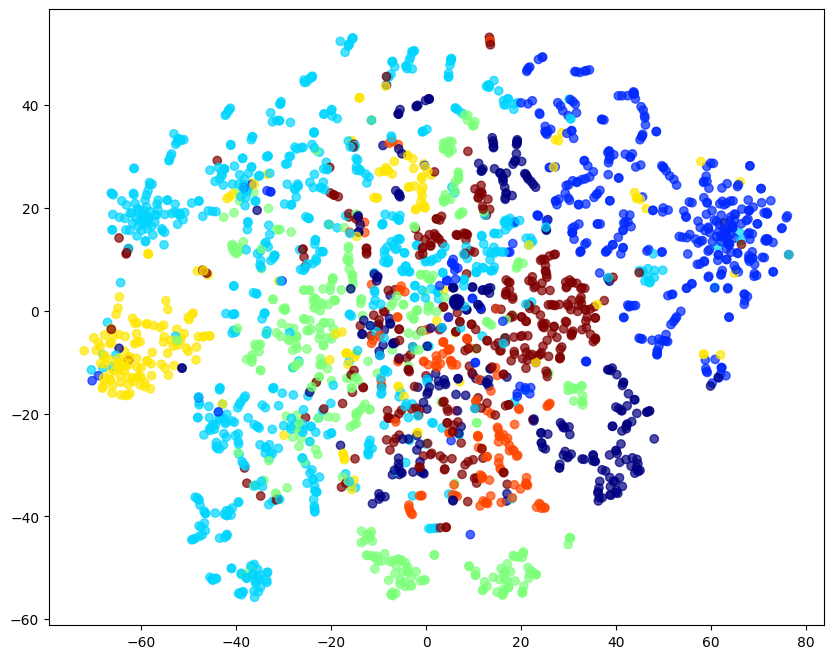

In [41]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [156]:
# Prepare for Dataset -----------------------------------------------------------------------------------
node_ids = np.array(node_ids, dtype=int)
node_embeddings = np.array(node_embeddings)

X1_train = np.zeros((140, 100))
Y_train = np.zeros(140)
X1_test = np.zeros((2345, 100))
Y_test = np.zeros(2345)

for i in range(140):
    j = np.argwhere(node_ids == nodes_random_walk[i])[0, 0]
    X1_train[i, :] = node_embeddings[j, :]
    Y_train[i] = node_colours[j]

i = 0
for j in range(2485):
    if (node_ids[j] not in nodes_random_walk):
        X1_test[i, :] = node_embeddings[j, :]
        Y_test[i] = node_colours[j]
        i += 1


Classification Results for Node2Vec


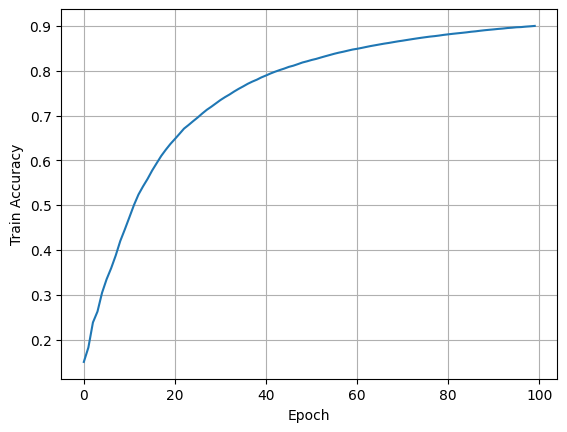

Test Accuracy:  tf.Tensor(0.5803838, shape=(), dtype=float32)


In [167]:
import tensorflow as tf
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.metrics import SparseCategoricalAccuracy


class MLP_Classifier(Model):
    
    def __init__(self, n_labels=7, n_channels1=1024, n_channels2=256, n_channels3=64, 
                 activation="relu", output_activation="softmax",
                 dropout_rate=0.5, l2_reg=2.5e-4, use_bias=False):
        super().__init__()
        self.dense1 = Dense(n_channels1, activation=activation, kernel_regularizer=l2(l2_reg), use_bias=use_bias)
        self.drop_out1 = Dropout(dropout_rate)
        self.dense2 = Dense(n_channels2, activation=activation, kernel_regularizer=l2(l2_reg), use_bias=use_bias)
        self.drop_out2 = Dropout(dropout_rate)
        self.dense3 = Dense(n_channels3, activation=activation, kernel_regularizer=l2(l2_reg), use_bias=use_bias)
        self.drop_out3 = Dropout(dropout_rate)
        self.out = Dense(n_labels, activation=output_activation, use_bias=use_bias)

    def call(self, inputs):
        X = self.dense1(inputs)
        X = self.drop_out1(X)
        X = self.dense2(X)
        X = self.drop_out2(X)
        X = self.dense3(X)
        X = self.drop_out3(X)
        X = self.out(X)
        return X


# Define Model --------------------------------------------------------------------------------------
model_1 = MLP_Classifier()


# Training ------------------------------------------------------------------------------------------ 
optimizer_1 = Adam(learning_rate=1e-2)
loss_fn_1 = SparseCategoricalCrossentropy()
acc_train_1 = SparseCategoricalAccuracy(name='train_accuracy')
n_epochs_1 = 100
arr_acc_train_1 = np.zeros(n_epochs_1)

for i in range(n_epochs_1):
    with tf.GradientTape() as tape:
        predicts = model_1(X1_train, training=True)
        loss = loss_fn_1(Y_train, predicts)
        loss += sum(model_1.losses)
    gradients = tape.gradient(loss, model_1.trainable_variables)
    optimizer_1.apply_gradients(zip(gradients, model_1.trainable_variables))
    arr_acc_train_1[i] = acc_train_1(Y_train, predicts)

print("Classification Results for Node2Vec")
plt.plot(range(n_epochs_1), arr_acc_train_1)
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.grid()
plt.show()


# Testing ------------------------------------------------------------------------------------------ 
acc_test_1 = SparseCategoricalAccuracy(name='test_accuracy')

predicts = model_1(X1_test, training=True)
accuracy = acc_test_1(Y_test, predicts)

print("Test Accuracy: ", accuracy)

Classification Results for Node2Vec


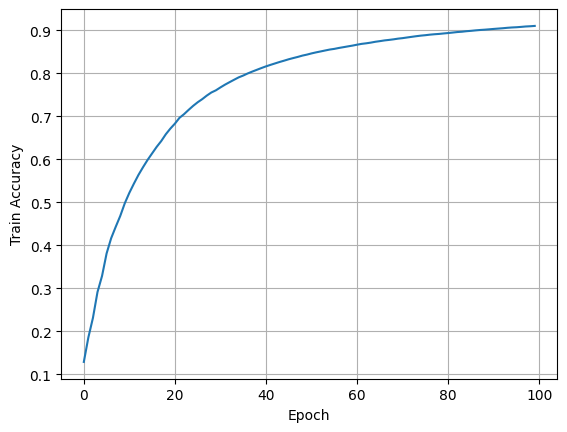

Test Accuracy:  tf.Tensor(0.5944563, shape=(), dtype=float32)


In [170]:
# Prepare for Dataset -----------------------------------------------------------------------------------
node_features = G.node_features()

X2_train = np.zeros((140, 1433))
X2_test = np.zeros((2345, 1433))

for i in range(140):
    j = np.argwhere(node_ids == nodes_random_walk[i])[0, 0]
    X2_train[i, :] = node_features[j, :]

i = 0
for j in range(2485):
    if (node_ids[j] not in nodes_random_walk):
        X2_test[i, :] = node_features[j, :]
        i += 1


# Define Model --------------------------------------------------------------------------------------
model_2 = MLP_Classifier()


# Training ------------------------------------------------------------------------------------------ 
optimizer_2 = Adam(learning_rate=1e-2)
loss_fn_2 = SparseCategoricalCrossentropy()
acc_train_2 = SparseCategoricalAccuracy(name='train_accuracy')
n_epochs_2 = 100
arr_acc_train_2 = np.zeros(n_epochs_2)

for i in range(n_epochs_2):
    with tf.GradientTape() as tape:
        predicts = model_2(X1_train, training=True)
        loss = loss_fn_2(Y_train, predicts)
        loss += sum(model_2.losses)
    gradients = tape.gradient(loss, model_2.trainable_variables)
    optimizer_2.apply_gradients(zip(gradients, model_2.trainable_variables))
    arr_acc_train_2[i] = acc_train_2(Y_train, predicts)

print("Classification Results for Node2Vec")
plt.plot(range(n_epochs_2), arr_acc_train_2)
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.grid()
plt.show()


# Testing ------------------------------------------------------------------------------------------ 
acc_test_2 = SparseCategoricalAccuracy(name='test_accuracy')

predicts = model_2(X1_test, training=True)
accuracy = acc_test_2(Y_test, predicts)

print("Test Accuracy: ", accuracy)

Classification Results for Node2Vec


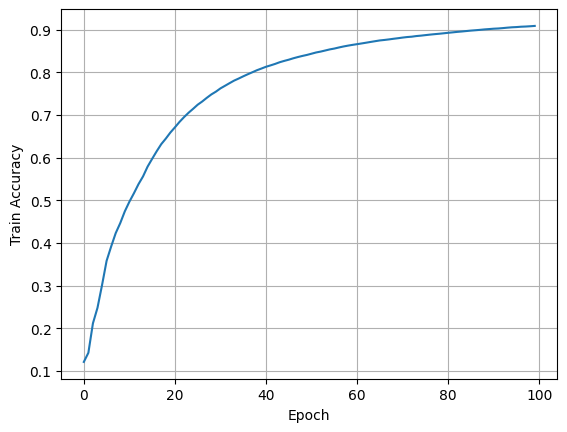

Test Accuracy:  tf.Tensor(0.60597014, shape=(), dtype=float32)


In [176]:
# Prepare for Dataset -----------------------------------------------------------------------------------
X3_train = np.concatenate([X1_train, X2_train], axis=1)
X3_test = np.concatenate([X1_test, X2_test], axis=1)


# Define Model --------------------------------------------------------------------------------------
model_3 = MLP_Classifier()


# Training ------------------------------------------------------------------------------------------ 
optimizer_3 = Adam(learning_rate=1e-2)
loss_fn_3 = SparseCategoricalCrossentropy()
acc_train_3 = SparseCategoricalAccuracy(name='train_accuracy')
n_epochs_3 = 100
arr_acc_train_3 = np.zeros(n_epochs_3)

for i in range(n_epochs_3):
    with tf.GradientTape() as tape:
        predicts = model_3(X1_train, training=True)
        loss = loss_fn_3(Y_train, predicts)
        loss += sum(model_3.losses)
    gradients = tape.gradient(loss, model_3.trainable_variables)
    optimizer_3.apply_gradients(zip(gradients, model_3.trainable_variables))
    arr_acc_train_3[i] = acc_train_3(Y_train, predicts)

print("Classification Results for Node2Vec")
plt.plot(range(n_epochs_3), arr_acc_train_3)
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.grid()
plt.show()


# Testing ------------------------------------------------------------------------------------------ 
acc_test_3 = SparseCategoricalAccuracy(name='test_accuracy')

predicts = model_3(X1_test, training=True)
accuracy = acc_test_3(Y_test, predicts)

print("Test Accuracy: ", accuracy)

* The simulation results for the three approaches are summarized as below:

> |               | Test Accuracy |
> | ------------- | ------------- |
> | Node2Vec      | 0.5803        |
> | TextFeatures  | 0.5944        |
> | Combined      | 0.6059        |

* Comparing $Node2Vec$ method and $TextFeatures$ method, we found the latter one outperforms by a small amount. We thought this is because there are more features in $TextFeatures$ method.
* Comparing the three methods, the combined one achieved highest accuracy because it contains more features data.

### QUESTION 25: Idea 3

In [3]:
!tar -zxvf cora.tgz

cora/
cora/README
cora/cora.cites
cora/cora.content


In [ ]:
import os
import numpy as np

import tensorflow as tf

import keras
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dropout
from keras.regularizers import l2
from keras.metrics import CategoricalAccuracy

import networkx as nx
import pandas as pd

import spektral
from spektral.datasets.citation import Cora
from spektral.layers import GCNConv
from spektral.transforms import AdjToSpTensor, LayerPreprocess

import matplotlib.pyplot as plt

import numpy as np
import random
import os
import networkx as nx
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy import dot
from numpy.linalg import norm


from collections import Counter
import matplotlib.pyplot as plt



# Define Hyperparameters ----------------------------------------------------------------------------
tf.random.set_seed(seed=0)
random.seed(0)


# Get Data Set --------------------------------------------------------------------------------------
all_data = []
all_edges = []

for root, dirs, files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file), 'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file), 'r') as f:
                all_edges.extend(f.read().splitlines())

categories = ['Reinforcement_Learning', 'Theory', 'Case_Based', 'Genetic_Algorithms', 'Probabilistic_Methods', 'Neural_Networks', 'Rule_Learning']
sorted(categories)
label_encoder = {}
i = 0
for cat in sorted(categories):
    label_encoder[cat] = i
    i +=1

labels = []
nodes = []
X = []
element_to_ind = {}

for i, data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(label_encoder[elements[-1]])
    X.append(elements[1:-1])
    nodes.append(elements[0])
    element_to_ind[elements[0]] = i
X = np.array(X,dtype=int)
N = X.shape[0]
F = X.shape[1]
print('X shape: ', X.shape)

edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))
num_classes = len(set(labels))


# Define Graph --------------------------------------------------------------------------------------
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)
G = nx.relabel_nodes(G, element_to_ind)
nodes = list(G.nodes)
df = pd.DataFrame(list(zip(nodes, labels, X)), columns=['node', 'label', 'features'])


# Get GCC Graph -------------------------------------------------------------------------------------
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
gcc_nodes = list(G.nodes)
df = df.loc[df['node'].isin(gcc_nodes)]
df['node'] = list(range(len(df)))
train = df.groupby('label', group_keys=False).apply(lambda x: x.sample(20))
G = nx.relabel_nodes(G, df['node'])


# Define Functions ----------------------------------------------------------------------------------
def create_transition_matrix(g):
    adj = nx.adjacency_matrix(g)
    transition_matrix = adj / adj.sum(axis=1)
    return transition_matrix


def random_walk(g, num_steps, start_node, transition_matrix=None):
    if transition_matrix is None:
        transition_matrix = create_transition_matrix(g)
    v = start_node
    for i in range(num_steps):
        PMF = transition_matrix[v, :]
        if (len(PMF.shape) == 2):
            PMF = np.array(PMF)[0,:]
        v = random.choices(np.array(df['node']), weights=np.array(PMF), k=1)[0]
    return v
    
    
def random_walk_with_teleportation(g, num_steps, start_node, tp=0.1, predicted=0, transition_matrix=None):
    if transition_matrix is None:
        transition_matrix = create_transition_matrix(g)
    v = start_node
    for i in range(num_steps):
        PMF = transition_matrix[v, :]
        if (len(PMF.shape) == 2):
            PMF = np.array(PMF)[0,:]
        rn = np.random.rand()
        if (rn < tp) :  # tp
            v = random.choices(np.array(seeds_dict[predicted]), k=1)[0]
        else:    # not tp
            v = random.choices(np.array(df['node']), weights=np.array(PMF), k=1)[0]     
    return v
     
  
    
seeds_dict = {predicted:list(train[train['label'] == predicted]['node']) for predicted in range(7)}

transition_matrix = create_transition_matrix(G)

n_samples = 1000
n_walk_steps = 100



# Without Telportation, Without TFIDF ----------------------------------------------------------------------------------
visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
    visiting_freq_label.append([0, 0, 0, 0, 0, 0, 0])
visiting_freq = [0 for i in range(transition_matrix.shape[0])]

for train_node, predicted in zip(train['node'], train['label']):
    for i in range(n_samples):
        start_point = train_node
        end_node = random_walk(G, n_walk_steps, start_point, transition_matrix)
        visiting_freq_label[end_node][predicted] += 1
        visiting_freq[end_node] +=1

count = 0
for vf in visiting_freq:
    if vf == 0:
        count += 1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)



# With Telportation 0.1, Without TFIDF -------------------------------------------------------------------------------------
visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
    visiting_freq_label.append([0, 0, 0, 0, 0, 0, 0])
visiting_freq = [0 for i in range(transition_matrix.shape[0])]

for train_node, predicted in zip(train['node'], train['label']):
    for i in range(n_samples):
        start_point = train_node
        end_node = random_walk_with_teleportation(G, n_walk_steps, start_point, tp=0.1, predicted=predicted, transition_matrix=transition_matrix)
        visiting_freq_label[end_node][predicted] += 1
        visiting_freq[end_node] +=1

count = 0 
for vf in visiting_freq:
    if vf == 0:
        count += 1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)



# With Telportation 0.2, Without TFIDF -------------------------------------------------------------------------------------
visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
    visiting_freq_label.append([0, 0, 0, 0, 0, 0, 0])
visiting_freq = [0 for i in range(transition_matrix.shape[0])]

for train_node, predicted in zip(train['node'], train['label']):
    for i in range(n_samples):
        start_point = train_node
        end_node = random_walk_with_teleportation(G, n_walk_steps, start_point, tp=0.2, predicted=predicted, transition_matrix=transition_matrix)
        visiting_freq_label[end_node][predicted] += 1
        visiting_freq[end_node] +=1

count = 0 
for vf in visiting_freq:
    if vf == 0:
        count += 1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)



# Get Transition Matrix for TFIDF ------------------------------------------------------------------------------------------
vs = list(G.nodes)
n = len(vs)
adj = nx.adjacency_matrix(G)
transition = np.zeros((len(G.nodes), len(G.nodes)))

for n1 in range(n):
    for n2 in range(n):
        if (adj[n1, n2] != 0):
            cos_sim = np.dot(X[n1], X[n2])
            transition[n1, n2] = np.exp(cos_sim) 
transition = (transition / transition.sum(axis=0)).transpose()



# Without Teleportation, With TFIDF ----------------------------------------------------------------------------------------
transition_matrix = np.matrix(transition)
visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
    visiting_freq_label.append([0, 0, 0, 0, 0, 0, 0])
visiting_freq = [0 for i in range(transition_matrix.shape[0])]

for train_node, predicted in zip(train['node'], train['label']):
    for i in range(n_samples):
        start_point = train_node
        end_node = random_walk(G, n_walk_steps, start_point, transition_matrix)
        visiting_freq_label[end_node][predicted] += 1
        visiting_freq[end_node] +=1

count = 0
for vf in visiting_freq:
    if vf == 0:
        count += 1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)



# With Teleportation 0.1, With TFIDF -------------------------------------------------------------------------------------------
visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
    visiting_freq_label.append([0, 0, 0, 0, 0, 0, 0])
visiting_freq = [0 for i in range(transition_matrix.shape[0])]

for train_node, predicted in zip(train['node'], train['label']):
    for i in range(n_samples):
        start_point = train_node
        end_node = random_walk_with_teleportation(G, n_walk_steps, start_point, tp=0.1, predicted=predicted, transition_matrix=transition_matrix)
        visiting_freq_label[end_node][predicted] += 1
        visiting_freq[end_node] +=1

count = 0 
for vf in visiting_freq:
    if vf == 0:
        count += 1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)



# With Teleportation 0.2, With TFIDF -------------------------------------------------------------------------------------------
visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
    visiting_freq_label.append([0, 0, 0, 0, 0, 0, 0])
visiting_freq = [0 for i in range(transition_matrix.shape[0])]

for train_node, predicted in zip(train['node'], train['label']):
    for i in range(n_samples):
        start_point = train_node
        end_node = random_walk_with_teleportation(G, n_walk_steps, start_point, tp=0.2, predicted=predicted, transition_matrix=transition_matrix)
        visiting_freq_label[end_node][predicted] += 1
        visiting_freq[end_node] +=1

count = 0 
for vf in visiting_freq:
    if vf == 0:
        count += 1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)

X shape:  (2708, 1433)
unvisited =  0
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       285
           1       0.78      0.91      0.84       406
           2       0.85      0.51      0.64       726
           3       0.82      0.68      0.74       379
           4       0.42      0.56      0.48       214
           5       0.30      0.82      0.44       131
           6       0.63      0.53      0.57       344

    accuracy                           0.65      2485
   macro avg       0.63      0.67      0.62      2485
weighted avg       0.71      0.65      0.66      2485

unvisited =  16
              precision    recall  f1-score   support

           0       0.63      0.80      0.70       285
           1       0.87      0.87      0.87       406
           2       0.88      0.55      0.67       726
           3       0.79      0.77      0.78       379
           4       0.55      0.83      0.67       214
           5       0.41 

0.6567404426559356

* The simulation results are summarized as follows:

>| Teleportation $p$ | Use TFIDF? | Accuracy | F1 Score |
>| -----             | -----      | -----    | -----    |
>| 0                 | NO         | 0.71     | 0.66     |
>| 0.1               | NO         | 0.75     | 0.71     |
>| 0.2               | NO         | 0.74     | 0.69     |
>| 0                 | YES        | 0.59     | 0.55     |
>| 0.1               | YES        | 0.73     | 0.69     |
>| 0.2               | YES        | 0.72     | 0.66     |

* Based on the results, we found that in terms of teleportation probability $p$, better accuracy and f1 score are achieved when $p=1$.
* Comparing $(a)$ and $(b)$, we found that better accuracy and f1 score are achieved when the probability of transitioning to neighbors is uniform.